## Imports

In [1]:
from simulator import *

import numpy             as np
import matplotlib.pyplot as plt
import os

No CUDA runtime is found, using CUDA_HOME='/opt/cuda'


In [2]:
cpp.get(realType = 'double')

Custom simulator C++ real type set to double
Loading C++ submodule from /media/hdd/study/sem-12/statmethods/simulator/cpp


<module 'cpp' from '/media/hdd/study/sem-12/statmethods/simulator/cpp/cpp.so'>

## Test amplitude distribution

Test amplitude shape:
* uphill: slope is $1.6$, starting at $P=0, E=9.5 \Rightarrow P = 1.6\left(E - 9.5\right)$
* downhill: slope is $-0.25$, starting at $P=1 \Rightarrow E_0 = \frac{1.0}{1.6} + 9.5, P = 1.0 - 0.25 \left( E - E_0 \right)$

In [3]:
E_test = np.linspace(0, 15, 1000)
E_0 = 1.0/1.6 + 9.5
P_test = np.zeros(1000)
P_test = 1.6*(E_test - 9.5)
P_test[E_test >= E_0] = (1.0 - 0.25 * (E_test - E_0))[E_test >= E_0]
P_test[P_test < 0] = 0

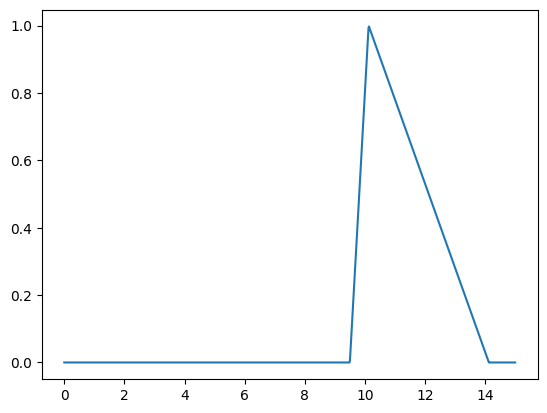

In [4]:
plt.plot(E_test, P_test)

## Probability distribution normalization

In [5]:
P_test = cpp.get().probNormalize(E_test, P_test)
# Two iterations of normalization should give the same result
assert(np.allclose(P_test, cpp.get().probNormalize(E_test, P_test)))

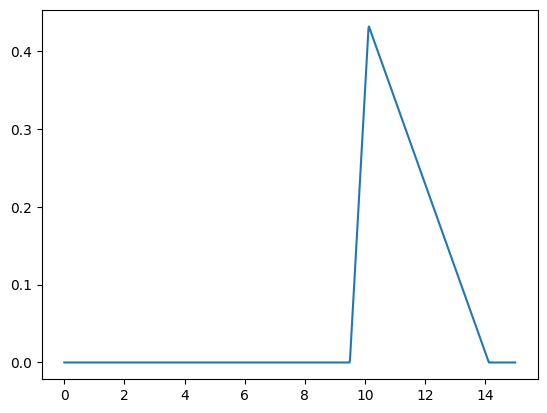

In [6]:
plt.plot(E_test, P_test)

## Load the example signal

The signals are loaded into a tuple where first element is $X$ axis and the second one is $Y$.

In [7]:
exampleSignal = ( [], [] )
with open('task/Shape_Etalon.txt') as exampleSignalFile:
    for line in exampleSignalFile.readlines():
        point = line.split('\t')
        for i in range(2):
            exampleSignal[i].append(float(point[i]))
exampleSignal = (
    np.array(exampleSignal[0]),
    np.array(exampleSignal[1])
)

### Utility: plot the signal

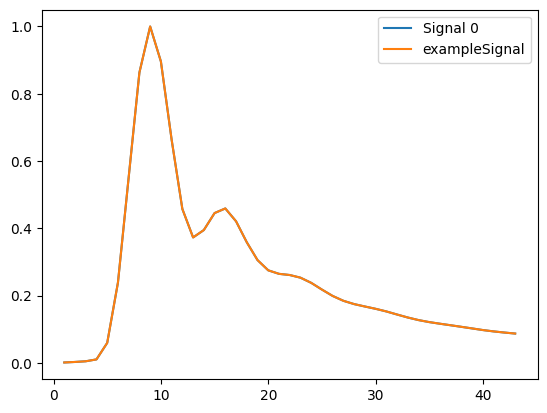

In [8]:
util.plotSignals(exampleSignal, exampleSignal=exampleSignal)

## Signal composition

We want to perform a linear composition (overlap) of two signals with offset:
$$
S(t) = A_1 S_1\left(t\right) + A_2 S_2\left(t - \tau\right)
$$

In [9]:
exampleSignalWithOffset = cpp.get().composeSignals(
    exampleSignal, exampleSignal,
    13, 1, 1
)

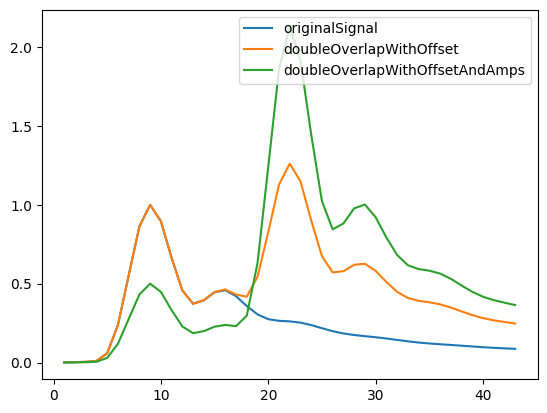

In [10]:
util.plotSignals(
    originalSignal=exampleSignal,
    doubleOverlapWithOffset=exampleSignalWithOffset,
    doubleOverlapWithOffsetAndAmps=cpp.get().composeSignals(
        exampleSignal, exampleSignal, 13, .5, 2
    )
)

## Integrate the composed signal

Here "inregration" means a sum of all the $Y$ axis values.
We assume that the $X$ axis grid is uniform.

## Roll signal amplitude

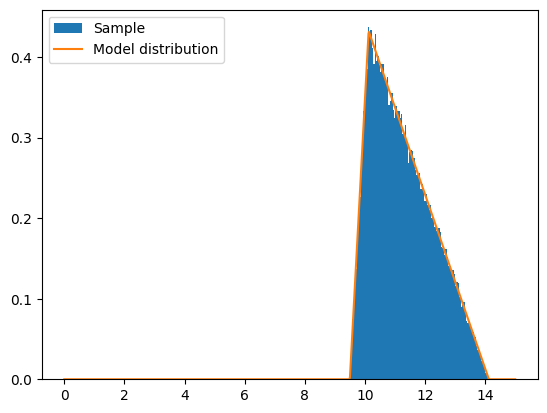

In [11]:
amps = [cpp.get().rollScalar(E_test, P_test) for i in range(100000)]
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

## Complete roll

When doing a complete roll, we need to roll all signals amplitudes and all of the offsets.
Amplitudes distribution is given by `P` and `E`, offset distribution is uniform in the integer interval between $0$ and $42$ (including $0$ and $42$).

In [12]:
tester = signals.SignalTester(P_test, E_test, exampleSignal)

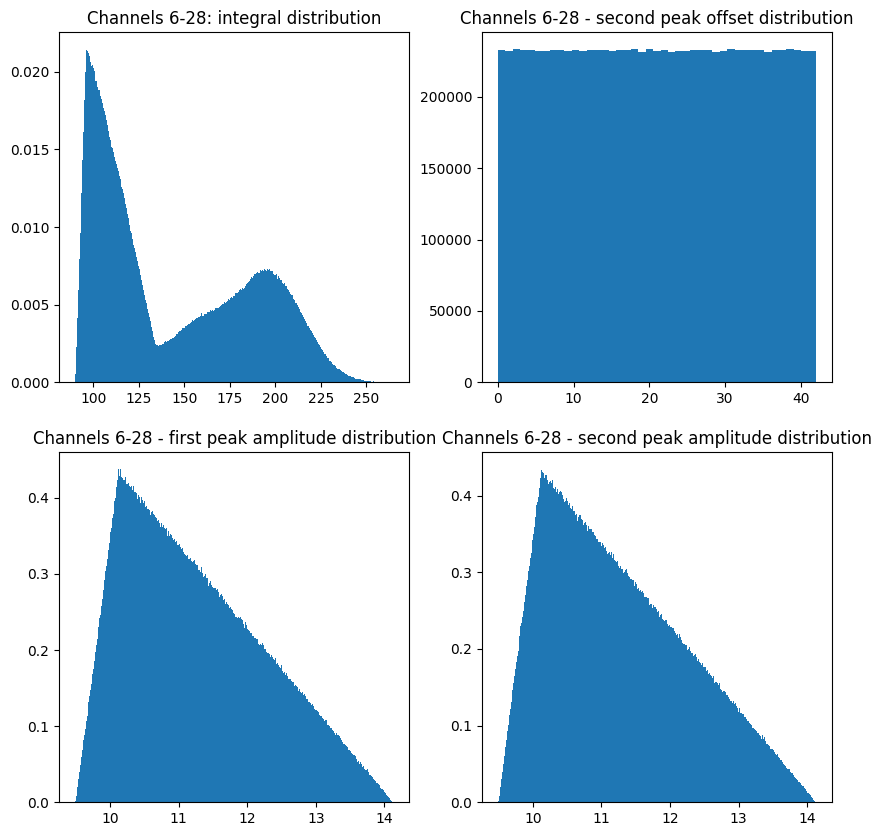

In [13]:
tester.run(3, 19)
tester.plot()

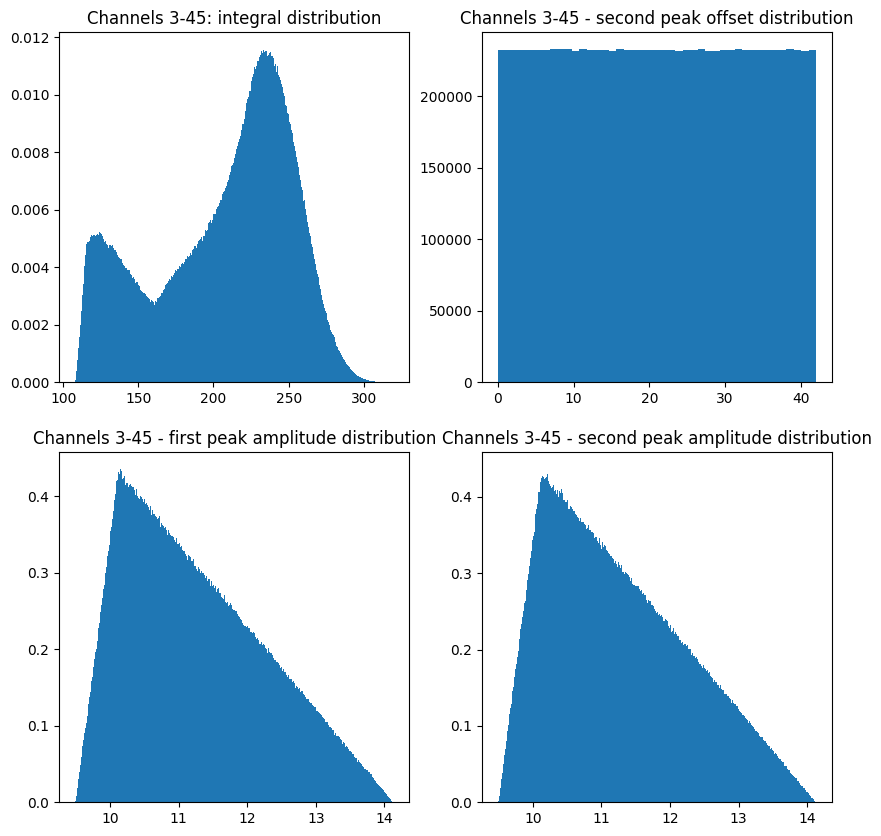

In [14]:
tester.run(6, 36)
tester.plot()

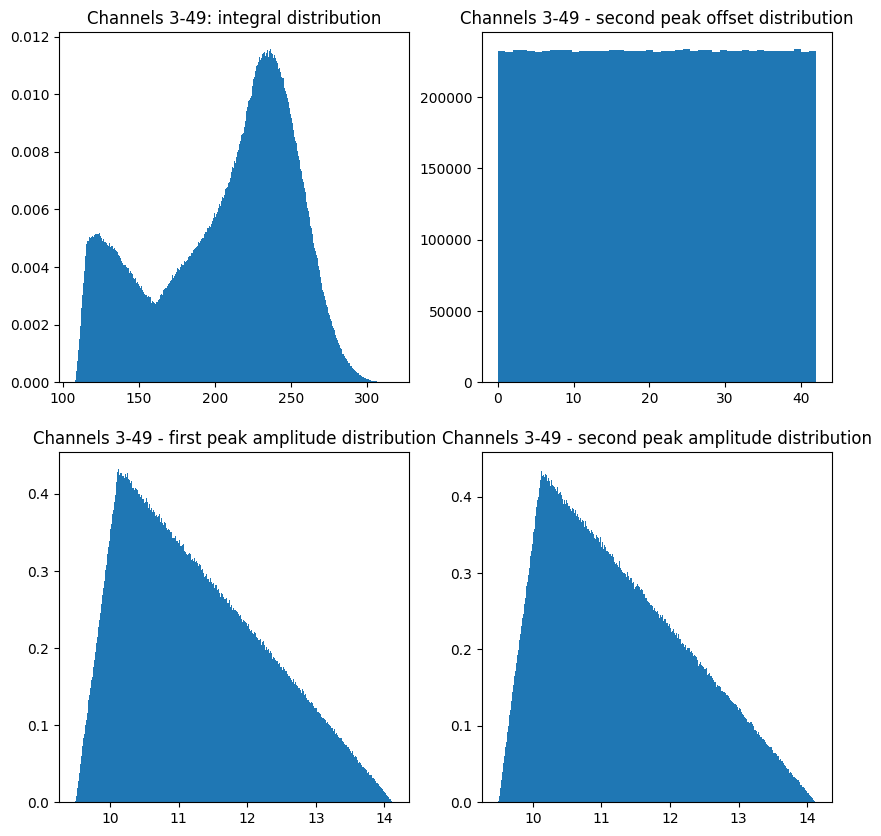

In [15]:
tester.run(6, 40)
tester.plot()

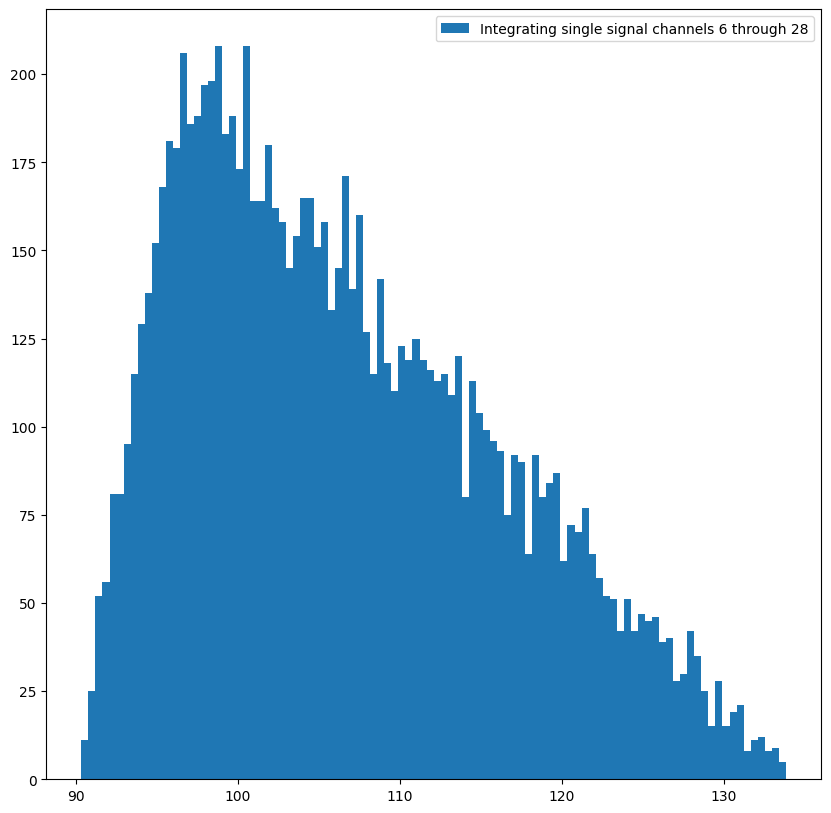

In [16]:
tester.runSingle(3, 19, 10_000)
tester.plot(bins=100)

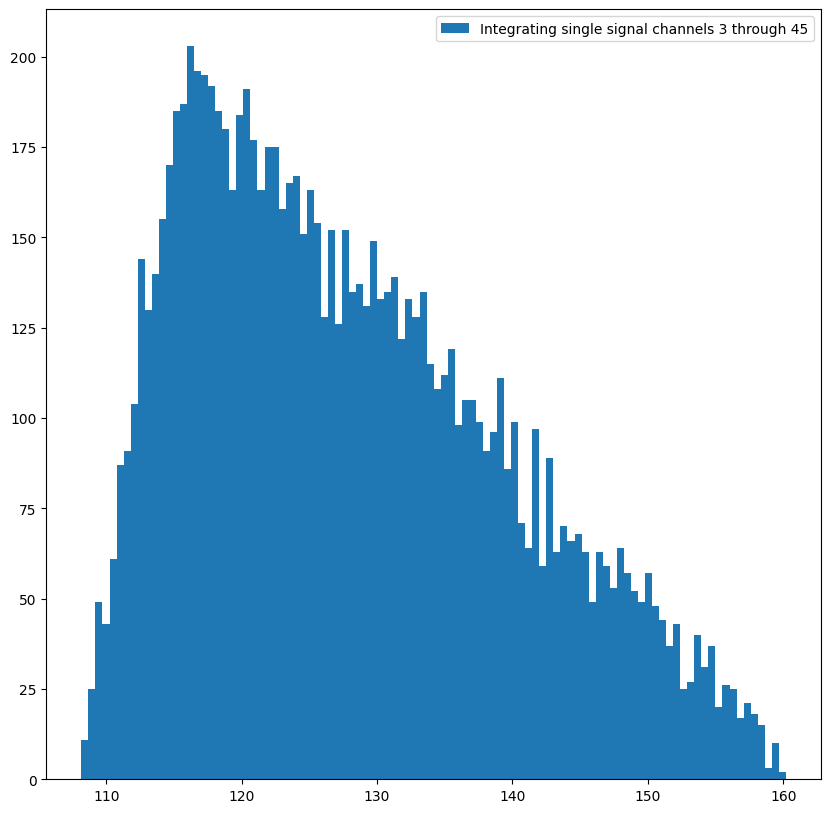

In [17]:
tester.runSingle(6, 36, 10_000)
tester.plot(bins=100)

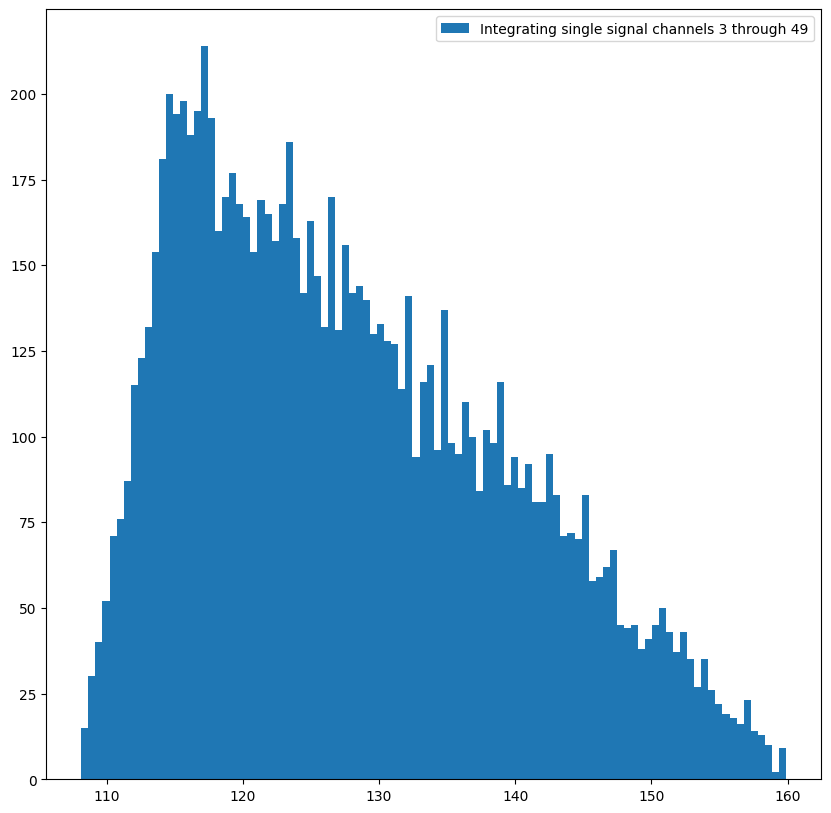

In [18]:
tester.runSingle(6, 40, 10_000)
tester.plot(bins=100)

## Experimental amplitude distribution

### One-peak signal

12000
12500
13000
13500


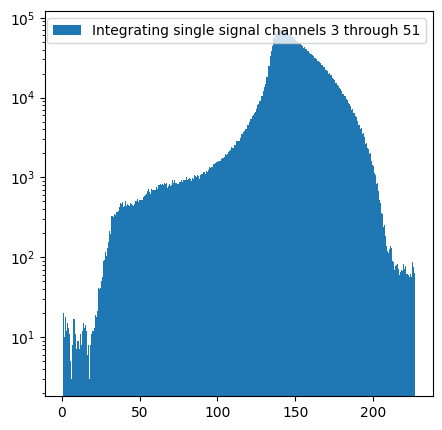

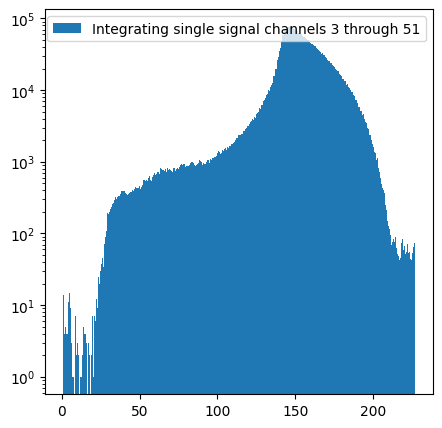

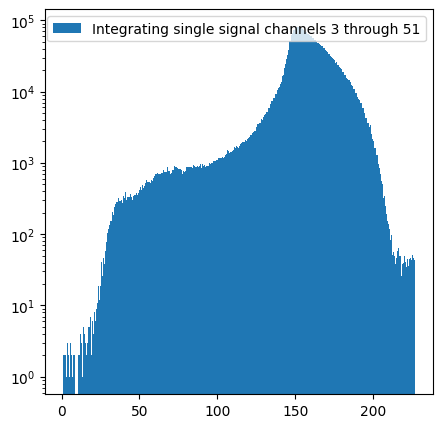

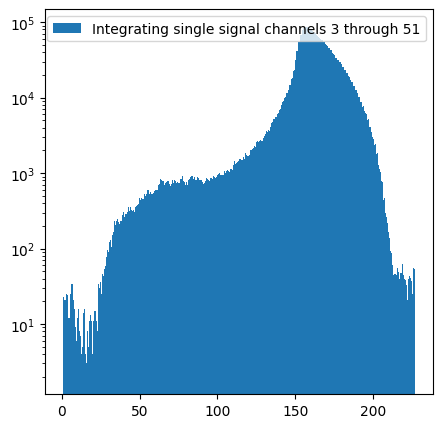

In [19]:
for pn, num in [
    ( "120", "12000"),
    ( "109", "12500"),
    ( "98",  "13000" ),
    ( "87",  "13500" ),
]:
    print(num)
    
    hvprob = util.loadExperimentalSignal(f"task/data/p{pn}(30s)(HV1={num})")
    assert(np.allclose(hvprob[1], cpp.get().probNormalize(hvprob[0], hvprob[1])))

    hv = signals.SignalTester(
        hvprob[1], hvprob[0],
        exampleSignal
    )
    hv.runSingle(6, 42)
    hv.plot(dump=f"task/output/{num}_single_6_42.txt", figsize=(5, 5), log=True)

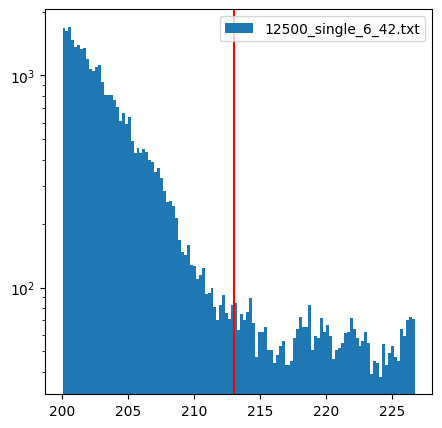

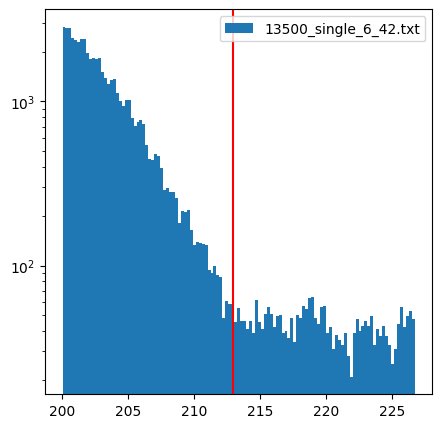

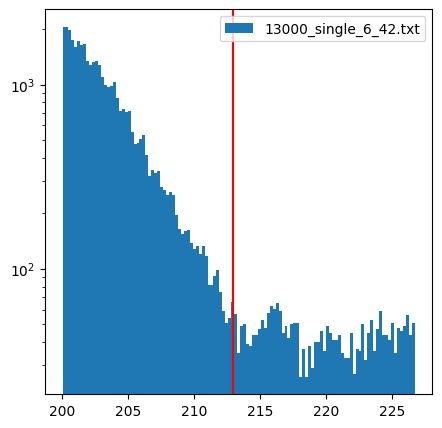

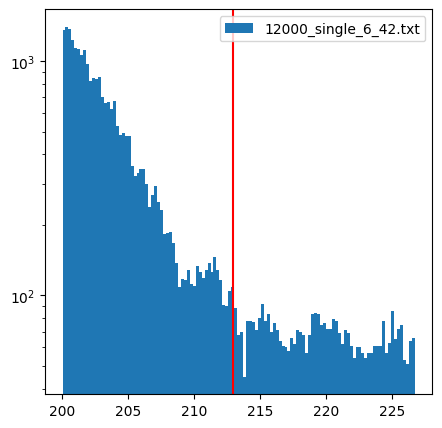

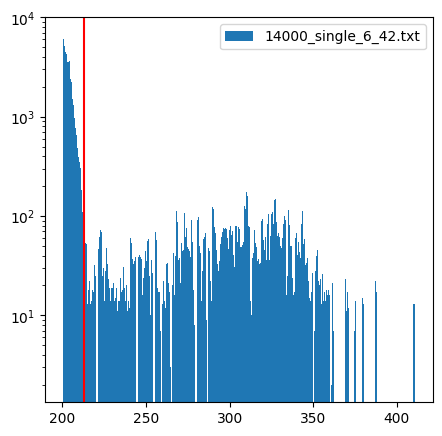

In [20]:
for hist in os.listdir("task/output"):
    if "_single" not in hist: continue
        
    data = util.readHistFile(os.path.join("task/output", hist))
    data = data[data[:,0] >= 200]
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(data[:,0], bins=len(data), weights=data[:,1], range=(min(data[:,0]), max(data[:,0])), label=hist)
    ax.set_yscale("log")
    ax.axvline(213, c='r')
    ax.legend()

### Two-peak signal

In [21]:
for pn, num in [
    ( "120", "12000" ),
    ( "109", "12500" ),
    ( "98",  "13000" ),
    ( "87",  "13500" ),
    ( "9",   "14000" ),
    ( "63",  "14500" ),
    ( "52",  "15000" ),
    ( "30",  "16000" ),
    ( "24",  "16500" ),
]:
    print(num)
    
    hvprob = util.loadExperimentalSignal(f"task/data/p{pn}(30s)(HV1={num})")
    assert(np.allclose(hvprob[1], cpp.get().probNormalize(hvprob[0], hvprob[1])))

    hv = signals.SignalTester(
        hvprob[1], hvprob[0],
        exampleSignal
    )
    hv.run(6, 42)
    hv.plot(dump=f"task/output/{num}_6_42.txt", draw=False)

12000
12500
13000
13500
14000
14500
15000
16000
16500


In [22]:
for hist in os.listdir("task/output"):
    if "_single" in hist: continue

    div = None
    if "6_36" in hist:
        div = 213
    elif "3_19" in hist:
        div = 170
    else:
        continue

    l, r = util.analyzeHistFile(os.path.join("task/output", hist), div)
    print(f"Hist file {hist} {l=}, {r=}, ratio={2 * (l + r) / r}")

Hist file 12500_3_19.txt l=1.6424987754561375, r=1.2525098478091674, ratio=4.622731914370367
Hist file 13000_3_19.txt l=1.5931677224381582, r=1.2669547390227553, ratio=4.514956017555957
Hist file 12500_6_36.txt l=0.6549657409121085, r=1.699990968448415, ratio=2.77055202417916
Hist file 12000_3_19.txt l=1.6864143347672989, r=1.2149905821763893, ratio=4.776012192203922
Hist file 13500_3_19.txt l=1.5374957905350188, r=1.2715047844849945, ratio=4.4183877391507576
Hist file 13500_6_36.txt l=0.5549118036399667, r=1.7525672953436102, ratio=2.6332559156094146
Hist file 13000_6_36.txt l=0.6119128967698821, r=1.7648807668911177, ratio=2.6934325629801976
Hist file 12000_6_36.txt l=0.7057696602320247, r=1.6110534711524764, ratio=2.8761592000135763


### Final analysis

Hist file 12500_6_42.txt l=0.6462605638609479, r=1.7006296036959079, ratio=2.7600250665476556
12500
Hist file 14000_6_42.txt l=0.5197599084812775, r=1.8456472727592828, ratio=2.5632277804677437
14000
Hist file 12000_6_42.txt l=0.7039920869750654, r=1.637053883421228, ratio=2.8600719794315066
12000
Hist file 15000_6_42.txt l=0.4719604352597804, r=1.8776701900621027, ratio=2.5027085563350937
15000
Hist file 16000_6_42.txt l=0.43568568587371526, r=1.9198839345179326, ratio=2.453866692710372
16000
Hist file 13000_6_42.txt l=0.5975854294615367, r=1.7486121123950717, ratio=2.683496843268488
13000
Hist file 13500_6_42.txt l=0.5651727474925731, r=1.8044378683573867, ratio=2.6264252789230813
13500
Hist file 16500_6_42.txt l=0.4147309851055552, r=1.9370436305866754, ratio=2.4282102669829335
16500
Hist file 14500_6_42.txt l=0.5002134342663269, r=1.8896749351747235, ratio=2.5294174410161987
14500


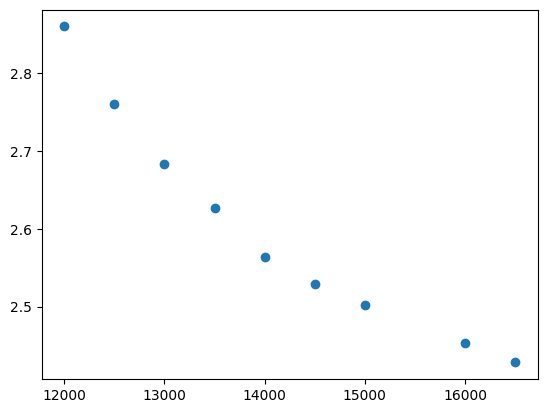

In [23]:
ratios = []
for hist in os.listdir("task/output"):
    if "_single" in hist: continue

    div = 213
    if "6_42" not in hist:
        continue

    l, r = util.analyzeHistFile(os.path.join("task/output", hist), div)
    print(f"Hist file {hist} {l=}, {r=}, ratio={2 * (l + r) / r}")
    
    print(hist[:5])
    ratios.append((float(hist[:5]), 2 * (l + r) / r))
    
plt.scatter(*(zip(*ratios)))